Convert output file from energy dispersive XRD on beamline 13-ID-D (APS) from detector channels to energy.

In [66]:
from numpy import sqrt, pi, exp, linspace, loadtxt, array, append
import matplotlib.pyplot as plt
import peakutils as pk
from lmfit import Model
import math

Load data file and read channel energy calibration factors and two theta from the first few lines, then find the line on which the data starts.

In [41]:
lookup = 'DATA'
filename='/home/nick/Nextcloud/python_vm_documents/ANU_LVP_APS_Nov2017/T2118/diff/T2118.026'
with open(filename) as file:
    for num, line in enumerate(file, 1):
        if 'CAL_OFFSET' in line:
            offsetline=line
        if 'CAL_SLOPE' in line:
            slopeline=line
        if 'TWO_THETA' in line:
            thetaline=line
        if lookup in line:
            datastart=num

Extract calibration coefficients and two theta as floats. 

In [42]:
offsetline=offsetline.split(':')
offset=float(offsetline[1])

slopeline=slopeline.split(':')
slope=float(slopeline[1])

thetaline=thetaline.split(':')
twotheta=float(thetaline[1])

Read data columns into numpy array and add channel numbers. Do a quick scan of all peaks, and plot diffraction pattern and peaks with channels on x axis.

Text(0,0.5,'Intensity')

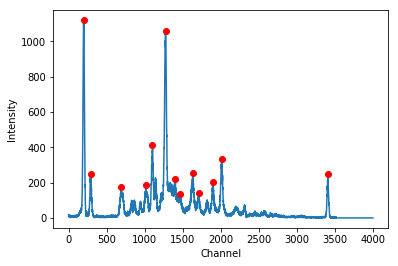

In [73]:
with open(filename) as file:
    for num, line in enumerate(file, 1):
        if lookup in line:
           datastart=num
data = np.loadtxt(filename, skiprows=datastart)
datalen = len(data)
number=range(0,datalen)
number=np.array(number)

indexesall=pk.indexes(data, thres=0.1, min_dist=70)

plt.figure()
plt.plot(number,data,'-')
plt.plot(number[indexesall],data[indexesall],'ro')
plt.xlabel('Channel')
plt.ylabel('Intensity')

Find peak in the range where the MgO 200 peak is expected, and plot this region with found peak(s).

Text(0,0.5,'Intensity')

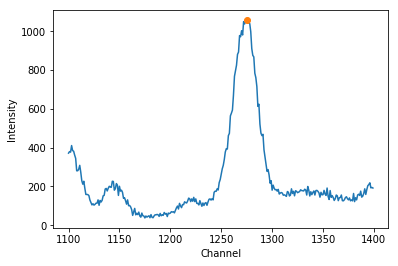

In [44]:
indexes=pk.indexes(data[1200:1350], thres=0.5, min_dist=50)+1200
plt.figure()
plt.plot(number[1100:1400],data[1100:1400],'-')
plt.plot(number[indexes], data[indexes],'o')
plt.xlabel('Channel')
plt.ylabel('Intensity')

Select region 50 either side of the peak.

In [45]:
MgO200min=indexes[0]-50
MgO200max=indexes[0]+50
    
datapeak=data[MgO200min:MgO200max]
numberpeak=number[MgO200min:MgO200max]

Find minima at either side of peak, and subtract a simple linear background underneath the peak.

In [46]:
# Save intensity without backgrounds as 'ywbg'
ywbg=datapeak

minlow=min(datapeak[0:10])
minhigh=min(datapeak[len(datapeak)-10:len(datapeak)])
diffbg=minhigh-minlow
gradbg=diffbg/len(datapeak)
bg=[]
bg=array(bg)
    
for i in range(0,len(datapeak)):
    bg=append(bg, minlow+i*gradbg)
    
# subtract background from data
datapeaksubbg=datapeak-bg

Fit gaussian (from a starting guess), using the lmfit software package (by M. Newville).

<bound method ModelResult.fit_report of <lmfit.model.ModelResult object at 0x7f1e553ab550>>


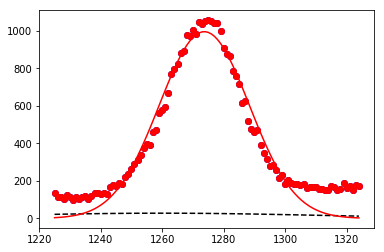

In [49]:
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))
gmodel = Model(gaussian)
result = gmodel.fit(datapeak, x=numberpeak, amp=3500, cen=1260, wid=50)

plt.plot(numberpeak, datapeak, 'bo')
plt.plot(numberpeak, ywbg, 'ro')
plt.plot(numberpeak, result.init_fit, 'k--')
plt.plot(numberpeak, result.best_fit, 'r-')

Print statistics of fit report. "cen:" is the centre of the peak.

In [54]:
print(result.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 100
    # variables        = 3
    chi-square         = 674020.934
    reduced chi-square = 6948.66942
    Akaike info crit   = 887.584626
    Bayesian info crit = 895.400137
[[Variables]]
    amp:  36589.6109 +/- 735.888655 (2.01%) (init = 3500)
    cen:  1273.70567 +/- 0.34028283 (0.03%) (init = 1260)
    wid:  14.6533257 +/- 0.34034968 (2.32%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) =  0.577



Get centre of peak from fit report.

In [62]:
for line in result.fit_report().splitlines():
    if 'cen:' in line:
        gauss_center=float(line[10:21])
print(gauss_center)

1273.70567


Convert centre of peak (in channel) to energy (keV).

In [64]:
energygauss=gauss_center*slope+offset
print(energygauss)

55.53486433333073


Convert from energy to d-spacing.

In [69]:
# first E=hc/lambda

# Convert energy from keV to joules

energy_joules=energy*1.6021773e-16
energygauss_joules=energygauss*1.6021773e-16

# Planck's constant m2/kg/s
h=6.626068e-34
# Speed of light m/s
c=299792456

# wavelength in metres
wavelength=(h*c)/energy_joules
wavelengthgauss=(h*c)/energygauss_joules

# convert wavelength to angstrom
angwavelength=wavelength*1e10
angwavelengthgauss=wavelengthgauss*1e10

# Bragg's law: n*lambda=2d*sin{theta}

radtheta=math.radians(twotheta/2)
twod=(angwavelength/math.sin(radtheta))
twodgauss=(angwavelengthgauss/math.sin(radtheta))

# Convert to angstrom

d=twod/2
dgauss=twodgauss/2

# Print d spacing of MgO 200 peak
print(dgauss)

2.0938688915149375


Print approximate d of all peaks (from peakutil peak positions). Plot d spacing spectrum, with all peaks. Note that this looks weird, because the conversion from channel/energy is not linear, and higher energy = lower d spacing.

[5.27839332 4.6650035  3.11557116 2.44603495 2.31556287 2.09234999
 1.9594704  1.88811932 1.7443242  1.68147392 1.55021194 1.48014701
 0.95304681]


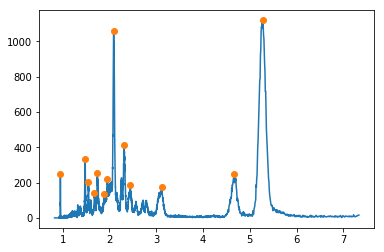

In [76]:
pyplot.figure()
pyplot.plot(d,data,'-')
pyplot.plot(d[indexesall],data[indexesall],'o')

print(d[indexesall])

To refine peaks other than MgO 200, adjust the range in which the second peak search and gaussian fitting are performed.